In [186]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# For use on local machine
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [2]:
# For use in google colab
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd LIDC_GDRO/

Cloning into 'LIDC_GDRO'...
remote: Enumerating objects: 3777, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 3777 (delta 210), reused 295 (delta 174), pack-reused 3428
Receiving objects: 100% (3777/3777), 82.66 MiB | 14.68 MiB/s, done.
Resolving deltas: 100% (3358/3358), done.
Checking out files: 100% (5414/5414), done.
/content/LIDC_GDRO


In [187]:
!git pull

Already up to date.


In [207]:
from utils import data_utils, image_data_utils
import datasets
import dataloaders
import models
import torch
import loss
import train_eval
import pandas as pd
import numpy as np
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [193]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 128

hparams = {"eta": 0.5, "gamma": 1}
lr = 0.0005
weight_decay = 0.005
# momentum = 0

model_class = models.NeuralNetwork
model_args = (512, 64, 36, 2)

# model_class = models.TransferModel50
# model_args = (True, False, device)


print(f'Using device {device}')

Using device cpu


# Load and process data

## LIDC

In [199]:
# get LIDC data

df = data_utils.preprocess_data(*data_utils.load_lidc(data_root="data/"))
df

,noduleID,Area,ConvexArea,Perimeter,ConvexPerimeter,EquivDiameter,MajorAxisLength,MinorAxisLength,Elongation,Compactness,...,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency,malignancy,subclass
0,1,2.786989,2.787828,2.621314,2.454225,2.468314,2.096066,2.748694,-0.570518,1.280735,...,-0.941970,1.182771,1.901636,-0.237301,1.094495,0.581531,-0.074923,0.036838,1,marked_malignant
1,2,2.208070,1.860850,1.503739,1.900692,2.116778,2.028013,1.857099,0.368191,-0.184960,...,-0.907012,1.393682,1.579543,-0.063547,1.072152,-1.152443,-0.649761,-0.649261,1,unmarked_malignant
2,3,2.250831,2.167998,2.131948,1.986969,2.143839,1.822497,2.130987,-0.259140,0.917787,...,-0.924491,1.423812,1.802531,-0.247131,1.362616,-0.477880,-0.241693,-0.158040,1,marked_malignant
3,4,-0.281938,-0.308556,-0.169450,-0.131188,-0.112305,-0.035113,-0.254287,0.706877,-0.144326,...,-0.522478,-0.142953,0.150768,-0.268456,-0.201422,-0.460583,-0.305796,-0.298158,1,marked_malignant
4,5,-0.002347,-0.076120,0.004412,0.124439,0.266908,-0.017849,0.457045,-1.040008,-0.500777,...,-0.679787,2.580808,0.481121,-0.107827,2.982511,0.166415,-0.106192,-0.042079,1,unmarked_malignant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,2686,0.849585,1.069459,1.451416,1.508525,1.126116,1.302069,1.377140,-0.009162,1.618966,...,-0.907012,0.574143,1.538249,-0.280163,0.290133,-0.162218,-0.100981,-0.013089,1,marked_malignant
2682,2687,-0.258913,-0.275351,-0.121906,-0.106743,-0.077760,-0.020100,-0.174450,0.471571,-0.060785,...,-0.522478,1.122511,0.167286,-0.248991,1.049808,-1.303787,-0.645070,-0.636376,1,marked_malignant
2683,2688,-0.624027,-0.601868,-0.690046,-0.740736,-0.762772,-0.713385,-0.763129,0.053998,-0.310221,...,0.508773,-0.841972,-0.823771,0.099402,-1.072814,-0.265997,-0.278174,-0.315875,0,unmarked_benign
2684,2689,-0.614159,-0.601868,-0.678509,-0.736229,-0.737945,-0.788747,-0.650570,-0.818325,-0.352348,...,0.351464,0.164374,-0.724665,-0.272902,-0.391340,-1.325408,-0.727934,-0.757168,0,unmarked_benign


In [212]:
# get train/test flags
train_split = pd.read_csv("data/train_test_splits/LIDC_data_split.csv")

# create train/test dataframes
train_df = df[df["noduleID"].isin(train_split[train_split["split"] == 0]["noduleID"].values)]
val_df = df[df["noduleID"].isin(train_split[train_split["split"] == 1]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_split[train_split["split"] == 2]["noduleID"].values)]

In [215]:
train_dataloader = data_utils.create_dataloader(train_df, batch_size)
val_dataloader = data_utils.create_dataloader(val_df, batch_size)
test_dataloader = data_utils.create_dataloader(test_df, batch_size)

## LIDC CNN features

In [220]:
cnn_train, cnn_val, cnn_test = image_data_utils.get_cnn_features(split_file='./data/subclass_labels/LIDC_data_split_with_cluster.csv')

In [221]:
train_dataloader = data_util.create_dataloader(cnn_train, batch_size=batch_size, is_dataframe=False)
val_dataloader = data_util.create_dataloader(cnn_val, batch_size=batch_size, is_dataframe=False)
test_dataloader = data_util.create_dataloader(cnn_test, batch_size=batch_size, is_dataframe=False)

## Waterbirds

In [7]:
# download waterbirds through wilds

!pip install wilds
from wilds import get_dataset

get_dataset(dataset="waterbirds", download=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 126 kB 15.3 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 3.1 MB 64.4 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=18dd8b92f34ec21aeb7fe10fa2428e1998aedbdea54d953bff90dcb45b6793ad
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


You can also download the dataset manually at https://wilds.stanford.edu/downloads.


0Byte [00:00, ?Byte/s]

Extracting data/waterbirds_v1.0/archive.tar.gz to data/waterbirds_v1.0

It took 1.6 minutes to download and uncompress the dataset.



In [8]:
from PIL import Image

[autoreload of PIL.Image failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: cannot import name 'DeferredError' from 'PIL._util' (/usr/local/lib/python3.7/dist-packages/PIL/_util.py)
]
[autoreload of PIL.ImageOps failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: module 'PIL.Image' has no attribute 'Resampling'
]


In [223]:
metadata_df = pd.read_csv('data/waterbirds_v1.0/metadata.csv')

In [224]:
convert_resize = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((200, 200), antialias=True)])

train_df, val_df, test_df = [metadata_df[metadata_df['split'] == split] for split in [0, 1, 2]]

dataset_list = []

for df in [train_df, val_df, test_df]:
    dataset_list.append(datasets.OnDemandImageDataset(df, 'data/waterbirds_v1.0/', transform=convert_resize, device=device))

In [225]:
# smaller dataloaders for prototyping
train_dataloader, test_dataloader, _ = [dataloaders.InfiniteDataLoader(torch.utils.data.Subset(dataset, range(0, len(dataset), 2)), batch_size=batch_size) for dataset in dataset_list]

In [226]:
# full size dataloaders
train_dataloader, test_dataloader, _ = [dataloaders.InfiniteDataLoader(dataset, batch_size=batch_size) for dataset in dataset_list]


# Test convergence of combinations of ERM and GDRO

In [152]:
N = 300
epochs = 15
# subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]
# subtypes = ["Overall", "Land on land", "Land on water", "Water on land", "Water on water"]
subtypes = ["Overall", "Benign", "Malignant1", "Malignant2"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Dynamic", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
# test_algorithms = ["ERM", "GDRO", *["Dynamic" + str(t) for t in [0.01, 0.05, 0.1, 0.5]]]
test_algorithms = ["ERM", "GDRO"]
keep_old =        [False, False]

record_roc_data = False

In [161]:
if not sum(keep_old):
    results = {}
    if record_roc_data:
        roc_data = {}  # For ROC curve

for a in range(len(test_algorithms)):
    algorithm = test_algorithms[a]

    if keep_old[a] and algorithm in results:
        print(f"Keeping old results for {algorithm}")
    else:
        print(f"Running test: {algorithm}")

        results[algorithm] = np.zeros(N * epochs * len(subtypes))
        if record_roc_data:
            roc_data[algorithm] = [None, None]

        for n in range(N):

            print(f"Trial {n + 1}/{N}")

            # create and train model
            # model = models.NeuralNetwork(64, 32, 32, 2)
            # model.to(device)
            model = model_class(*model_args)

            if (algorithm == "ERM"):
                loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams, subclassed=True)
            elif (algorithm == "GDRO"):
                loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1, normalize_loss=False)
            elif (algorithm == "NormGDRO"):
                loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["eta"], len(subtypes) - 1, normalize_loss=True)
            elif (algorithm.startswith("GDRO")):
                loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("GDRO"):]), len(subtypes) - 1, normalize_loss=True)
            elif (algorithm == "Dynamic"):
                loss_fn = loss.DynamicERMGDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["eta"], hparams["gamma"], len(subtypes) - 1)
            elif (algorithm.startswith("Dynamic")):
                loss_fn = loss.DynamicERMGDROLossAlt(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("Dynamic"):]), hparams["gamma"], len(subtypes) - 1)
            elif (algorithm == "Upweight"):
                loss_fn = loss.UpweightSmall(model, torch.nn.CrossEntropyLoss(), len(subtypes) - 1)
            else:
                loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)#, momentum=momentum)

            scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=2, verbose=True)
            
            for epoch in range(epochs):
                print(f'Epoch {epoch + 1} / {epochs}')

                if algorithm == "Sharp":
                    loss_fn.t = epoch / epochs < 0.5  # sharp boundary
                elif algorithm == "Smooth":
                    loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
                elif algorithm == "ReverseSmooth":
                    loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
                elif algorithm == "ExtraERM":
                    loss_fn.t = 2
                elif algorithm == "ExtraGDRO":
                    loss_fn.t = -1
                elif algorithm == "Halfway":
                    loss_fn.t = 0.5
                elif algorithm.startswith("Mix"):
                    loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

                train.train(train_dataloader, model, loss_fn, optimizer)
                sensitivities = train.test(test_dataloader, model, num_subclasses=len(subtypes) - 1)
                
                scheduler.step(train.test(val_dataloader, model, num_subclasses=len(subtypes) - 1)[0])

                for i in range(len(subtypes)):
                    results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]
            if record_roc_data:
                with torch.no_grad():
                    preds = model(torch.stack(test_dataloader.dataset.features))
                    probabilities = torch.nn.functional.softmax(preds, dim=1)[:, 1]
                    labels = test_dataloader.dataset.labels
                    if ROCData[algorithm][0] == None:
                        ROCData[algorithm][0] = probabilities
                        ROCData[algorithm][1] = labels
                    else:
                        ROCData[algorithm][0] += probabilities
        if record_roc_data:
            ROCData[algorithm][0] /= N
        
print("Test complete")

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

worst_group = results_df.stack().unstack(level=2).min(axis=1).unstack()
worst_group.index = pd.MultiIndex.from_tuples([(*idx, "Worst") for idx in worst_group.index], names=["trial", "epoch", "subtype"])

worst_concat = pd.concat([results_df, worst_group])
trial_means = worst_concat.unstack().unstack().mean(axis=0).unstack(level=0).unstack(level=0).stack()

# Automatically save and download results from colab
# results_df.to_csv('results.csv')

# from google.colab import files
# from datetime import datetime
# files.download(f'results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv') 

Running test: ERM
Trial 1/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 2.0000e-04.
Epoch 14 / 15
Epoch 15 / 15
Trial 2/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-04.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-05.
Epoch 15 / 15
Trial 3/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 2.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 4.0000e-05.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Trial 4/300
Epoch 1 / 15
Epoch 2 

Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 1.6000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 24/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 25/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007

Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 44/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 45/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 8.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducin

Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-05.
Epoch 15 / 15
Trial 65/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-04.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 66/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoc

Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 8.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Trial 86/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 1.6000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 87/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-04

Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 106/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 4.0000e-05.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 8.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 1.6000e-06.
Trial 107/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-04.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Trial 108/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epo

Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-05.
Epoch 15 / 15
Trial 127/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 2.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 4.0000e-05.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 8.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 1.6000e-06.
Trial 128/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 4.0000e-05.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 8.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning r

Epoch 00014: reducing learning rate of group 0 to 4.0000e-05.
Epoch 15 / 15
Trial 148/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 2.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-05.
Epoch 14 / 15
Epoch 15 / 15
Trial 149/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-04.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-05.
Epoch 15 / 15
Trial 150/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-04.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012

Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 8.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 1.6000e-06.
Epoch 15 / 15
Trial 171/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-05.
Epoch 14 / 15
Epoch 15 / 15
Trial 172/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-04.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-05.
Epoch 15 / 15
Trial 173/300

Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 8.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 1.6000e-06.
Epoch 15 / 15
Trial 191/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 2.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 4.0000e-05.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 8.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 1.6000e-06.
Trial 192/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 /

Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 8.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Trial 211/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-04.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-05.
Epoch 14 / 15
Epoch 15 / 15
Trial 212/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 213/300

Trial 230/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-04.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 231/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 232/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reduc

Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-06.
Trial 251/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 252/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
E

Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 4.0000e-05.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 8.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 1.6000e-06.
Trial 273/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 274/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-04.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 4.000

Trial 294/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 8.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 1.6000e-06.
Epoch 15 / 15
Trial 295/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 296/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e

Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 4.0000e-05.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 8.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 1.6000e-06.
Trial 15/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 1.6000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 16/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 1

Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-04.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-06.
Trial 35/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 1.6000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 36/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 1

Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 55/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-04.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 4.0000e-05.
Trial 56/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 2.0000e-04.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 4.0000e-05.
Trial 57/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005:

Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 1.6000e-06.
Trial 75/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 2.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 76/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-04.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-05.
Epoch 15 / 15
Trial 77/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 

Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 1.6000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 96/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 97/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducin

Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 8.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 1.6000e-06.
Epoch 15 / 15
Trial 116/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 1.6000e-06.
Epoch 15 / 15
Trial 117/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 2.0000e-04.
Epoch 10 / 15
Epoch 11 / 15
Epoch 1

Epoch 00012: reducing learning rate of group 0 to 8.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Trial 135/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-05.
Epoch 14 / 15
Epoch 15 / 15
Trial 136/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 2.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 4.0000e-05.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 8.0000e-06.
Trial 137/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 2

Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 1.6000e-06.
Epoch 15 / 15
Trial 155/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-04.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 156/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 8.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 1.6000e-06.
Epoch 15 / 15
Trial 157/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 

Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Trial 176/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 1.6000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 177/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-04.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 178/300
Epoch 1 / 15
Epoch 2 / 15

Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 196/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 8.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 1.6000e-06.
Epoch 15 / 15
Trial 197/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 2.0000e-04.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch

Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 1.6000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 217/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 2.0000e-04.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Trial 218/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: r

Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 238/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 00005: reducing learning rate of group 0 to 2.0000e-04.
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 8.0000e-06.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Trial 239/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 1

Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 2.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 4.0000e-05.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 8.0000e-06.
Epoch 15 / 15
Trial 258/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 2.0000e-04.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 4.0000e-05.
Epoch 14 / 15
Epoch 15 / 15
Trial 259/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 00008: reducing learning rate of group 0 to 4.0000e-05.
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning

Epoch 15 / 15
Trial 278/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 00011: reducing learning rate of group 0 to 2.0000e-04.
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 00014: reducing learning rate of group 0 to 4.0000e-05.
Epoch 15 / 15
Trial 279/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 00010: reducing learning rate of group 0 to 8.0000e-06.
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 1.6000e-06.
Trial 280/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: redu

Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 298/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 00004: reducing learning rate of group 0 to 2.0000e-04.
Epoch 5 / 15
Epoch 6 / 15
Epoch 7 / 15
Epoch 00007: reducing learning rate of group 0 to 4.0000e-05.
Epoch 8 / 15
Epoch 9 / 15
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 13 / 15
Epoch 00013: reducing learning rate of group 0 to 8.0000e-06.
Epoch 14 / 15
Epoch 15 / 15
Trial 299/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 3 / 15
Epoch 4 / 15
Epoch 5 / 15
Epoch 6 / 15
Epoch 00006: reducing learning rate of group 0 to 2.0000e-04.
Epoch 7 / 15
Epoch 8 / 15
Epoch 9 / 15
Epoch 00009: reducing learning rate of group 0 to 4.0000e-05.
Epoch 10 / 15
Epoch 11 / 15
Epoch 12 / 15
Epoch 00012: reducing learning rate of group 0 to 8.0000e-06.
Epoch 13 / 15
Epoch 14 / 15
Epoch 15 / 15
Epoch 00015: reducing learning rate of group 0 to 1.6000e-06.
Trial 300/300
Epoch 1 / 15
Epoch 2 / 15
Epoch 

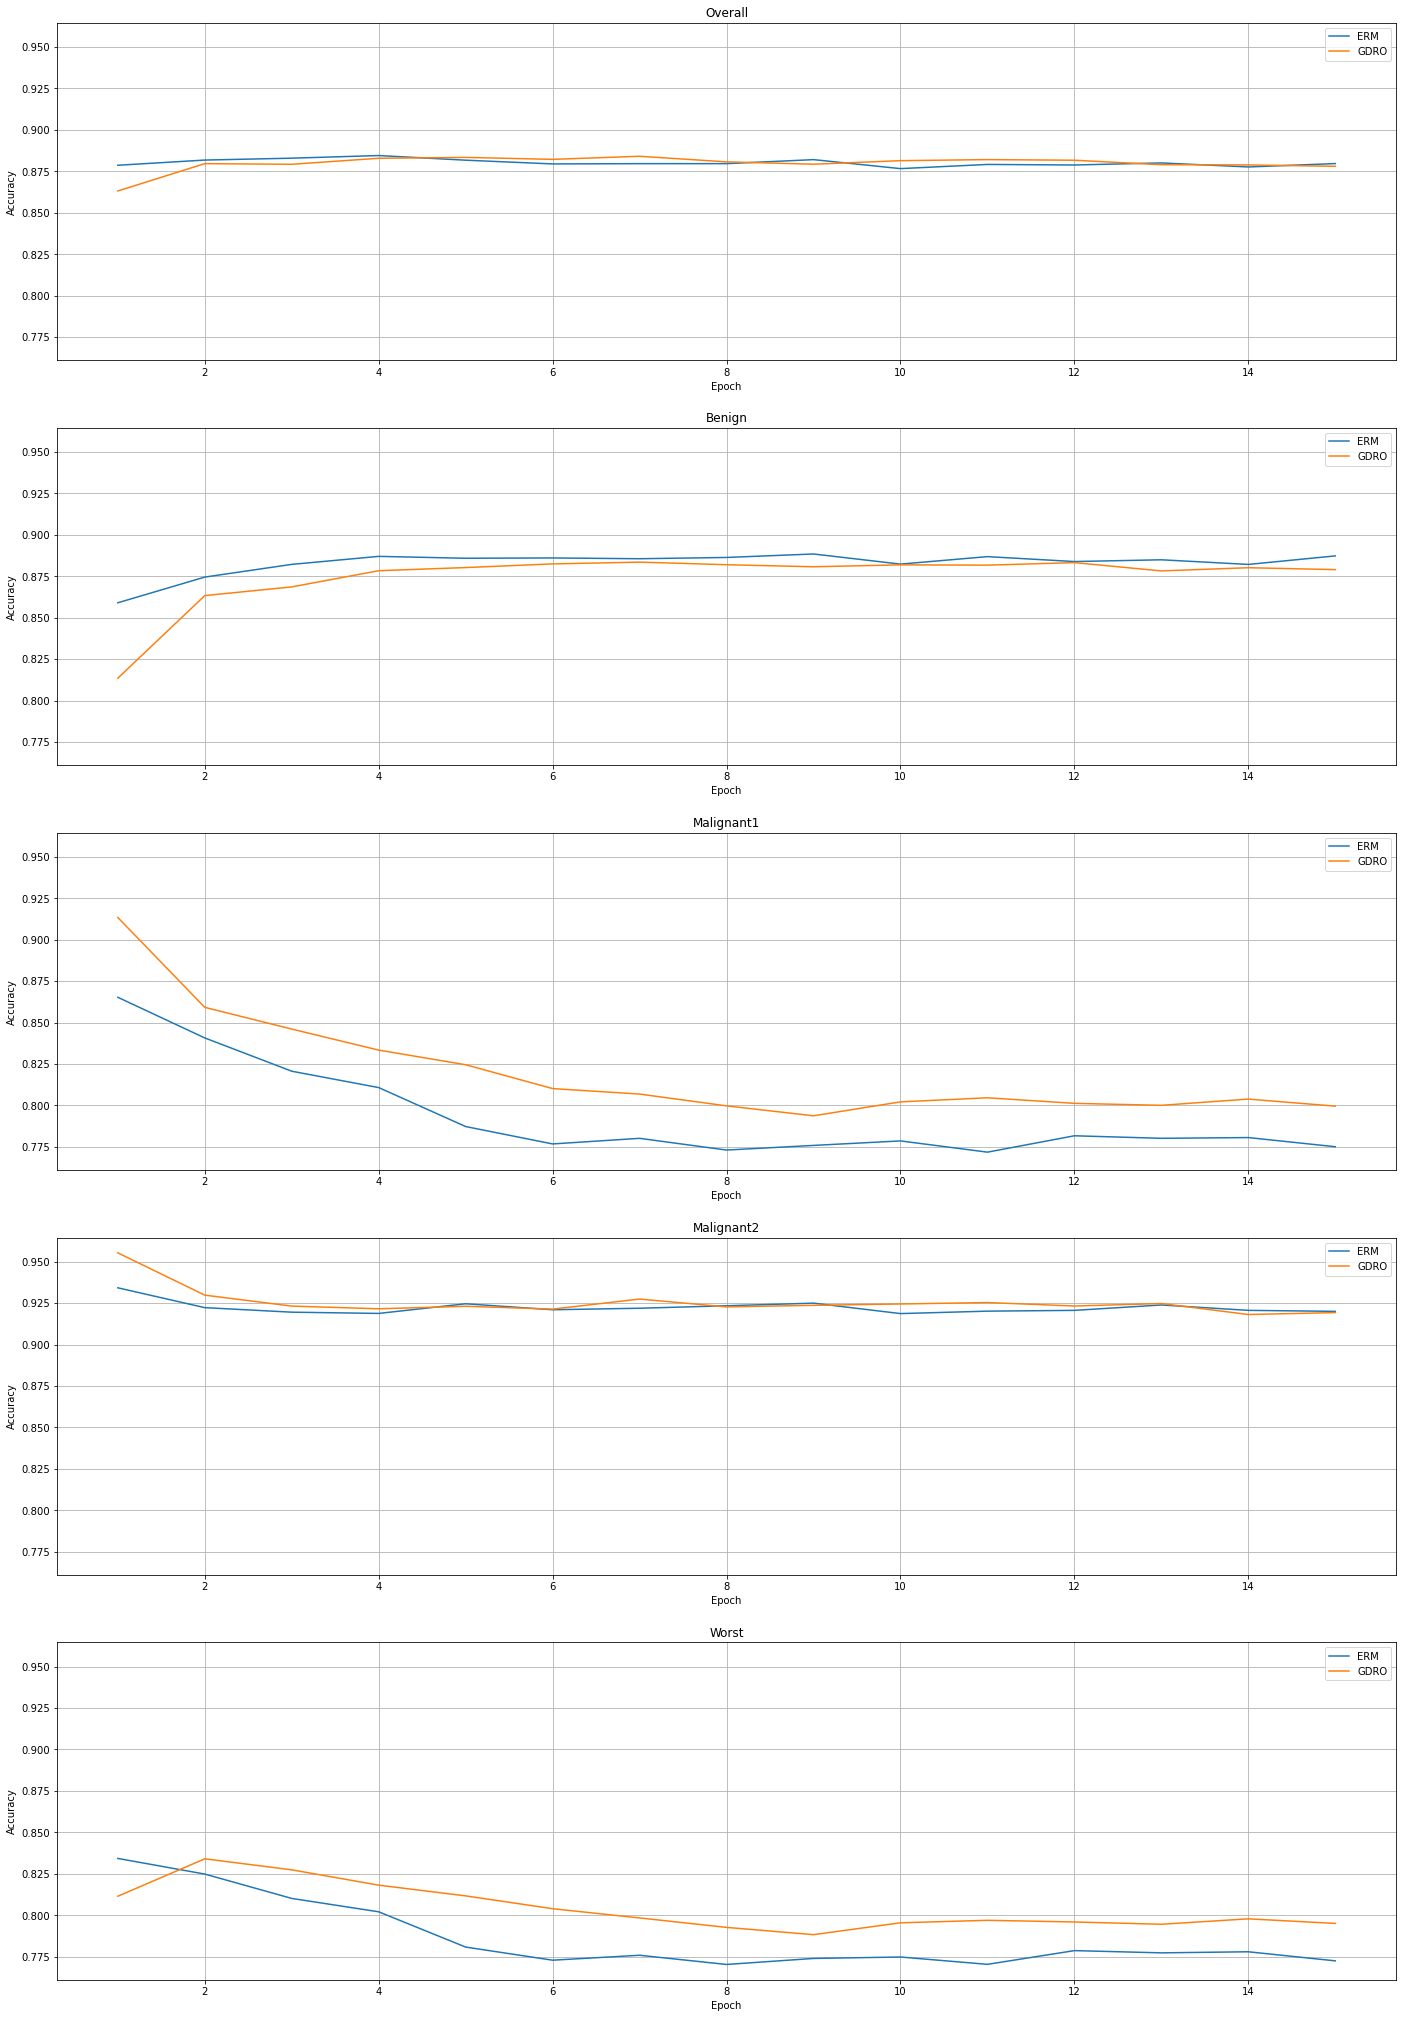

In [166]:
import matplotlib.pyplot as plt

rolling_window = 1

rolling_data = trial_means.unstack(level=1).rolling(rolling_window).mean().stack()
# reindex epochs from 1
rolling_data.index = pd.MultiIndex.from_tuples(zip(rolling_data.index.get_level_values(0) + 1, rolling_data.index.get_level_values(1)), names=["epoch", "subtype"])

plots = [*subtypes, "Worst"]

hide = []

f, a = plt.subplots(len(plots), 1, sharey=True)

# plot subtypes sensitivity

#legend=None,xlim=[55, 60],ylim=[0.85,0.88],

for i in range(len(plots)):
    rolling_data.drop(columns=hide).xs(plots[i], level=1).plot(xlabel="Epoch",ylabel="Accuracy",kind='line',title=plots[i],ax=a[i],figsize=(24,36),grid=True)

AttributeError: 'tuple' object has no attribute 'numpy'

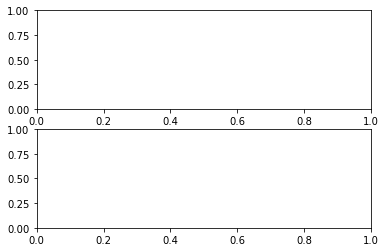

In [235]:
# ROC curve

from sklearn import metrics

f, a = plt.subplots(len(roc_data), 1)

for i in range(len(roc_data)):
    algorithm = list(roc_data.keys())[i]
    y_true = roc_data[algorithm][1].numpy()
    y_score = roc_data[algorithm][0].numpy()

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print(auc)
    a[i].plot(fpr, tpr, 'b')
    a[i].set_title(algorithm)

Overall
ERM: 0.8796744791666666
GDRO: 0.8780338541666667
No significant difference with p = 0.33

Benign
ERM: 0.8872537084652428
GDRO: 0.8789717009363407
ERM greater with p = 0.00

Malignant1
ERM: 0.7750641813979885
GDRO: 0.7995500169821625
GDRO greater with p = 0.00

Malignant2
ERM: 0.9200355649827967
GDRO: 0.9192837708118256
No significant difference with p = 0.78



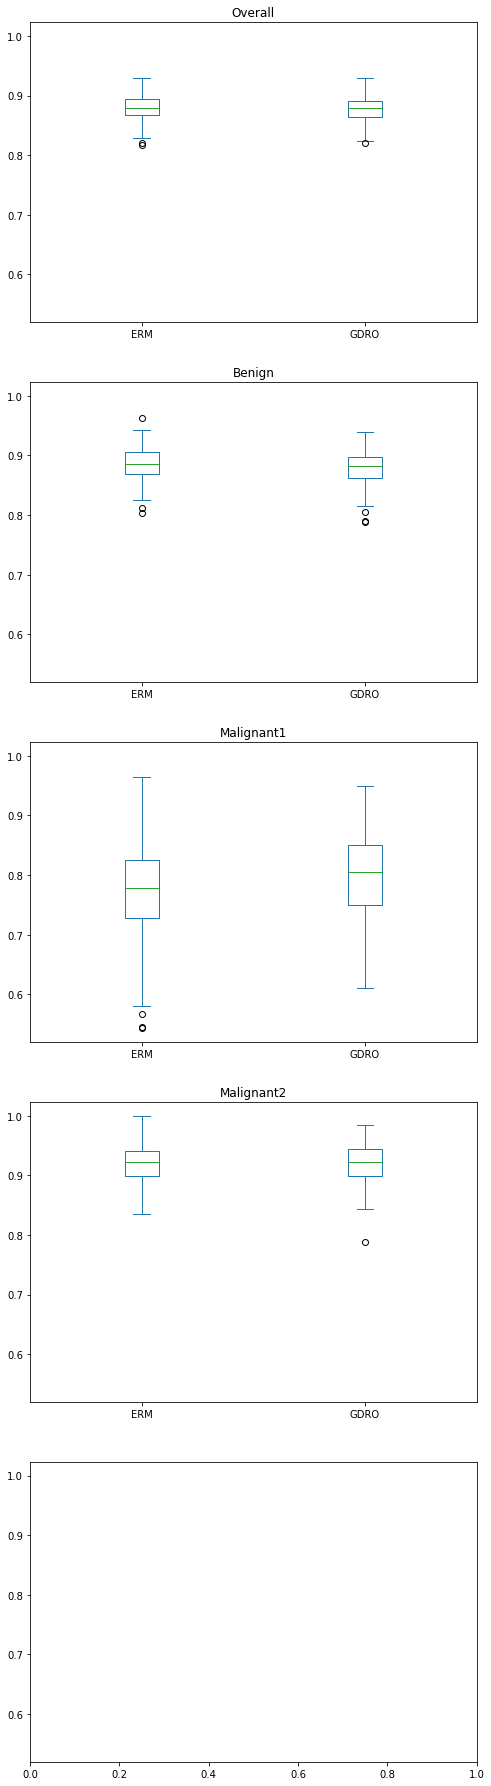

In [169]:
# statisitical tests comparing to ERM
from scipy.stats import ttest_ind
from IPython.display import display
import seaborn as sns

significance_threshold = 0.05

ttest_dataframes = {}

f, a = plt.subplots(len(subtypes) + 1,1, sharey=True, figsize=(8,32))

for s in range(len(subtypes)):
#     print(subtype)
#     print()
    subtype_data = results_df.xs(subtypes[s], level=2).xs(epochs - 1, level=1)
    subtype_data.plot(title=subtypes[s], kind='box', ax=a[s])
    
    # worst group data
    # results_df.stack().unstack(level=2).min(axis=1).unstack().xs(epochs - 1, level=1).plot(title='worst', kind='box', ax=a[-1])

    
    erm_data = subtype_data["ERM"].values

    print(subtypes[s])
    for algorithm in results_df.columns:
        if algorithm != "ERM":
            algorithm_data = subtype_data[algorithm].values
            stat, p = ttest_ind(algorithm_data, erm_data)

            print(f'ERM: {erm_data.mean()}')
            print(f'{algorithm}: {algorithm_data.mean()}')
            if p < significance_threshold:
                print(f'{algorithm if stat > 0 else "ERM"} greater with p = {p:.2f}')
            else:
                print(f'No significant difference with p = {p:.2f}')
            print()

In [ ]:
results_df.xs(subtype, level=2).xs(epochs - 1, level=1)

,ERM,GDRO,Dynamic,Upweight
trial,,,,
0,0.859375,0.898438,0.890625,0.855469
1,0.867188,0.843750,0.878906,0.847656
2,0.851562,0.867188,0.878906,0.855469
3,0.851562,0.851562,0.886719,0.914062
4,0.882812,0.832031,0.902344,0.882812
5,0.882812,0.832031,0.890625,0.847656
6,0.859375,0.894531,0.902344,0.859375
7,0.894531,0.777344,0.863281,0.921875
8,0.882812,0.832031,0.875000,0.871094


In [ ]:
# save results
results_df.to_csv('test_results/LIDC__fc64_36_36_2__Adam__eta_0_05__gamma_1_0__lr_0_001__weightdecay_0_0001__momentum_0_9.csv')

In [1]:
loaded_df = pd.read_csv('test_results/results(1).csv')
N = max(loaded_df["trial"]) + 1
epochs = max(loaded_df["epoch"]) + 1
subtypes = list(loaded_df["subtype"].unique())
algorithms = loaded_df.columns

results = loaded_df.drop(columns=["subtype", "epoch", "trial"]).to_dict('list')

NameError: name 'pd' is not defined

# GDRO Demonstration

In [ ]:
epochs = 30
N = 1

q_data = {}

for n in range(N):

    q_data[f'Trial_{n}'] = []
    
    model = model_class(*model_args)

    loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1, normalize_loss=True, subclassed=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn.t = 0

    q_data[f'Trial_{n}'].extend([1 / (len(subtypes) - 1) for i in range(len(subtypes) - 1)])
    for epoch in range(epochs):
        train.train(train_dataloader, model, loss_fn, optimizer)
        q_data[f'Trial_{n}'].extend(loss_fn.gdro.q.tolist())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
q_df = pd.DataFrame(q_data, index=pd.MultiIndex.from_product([range(epochs + 1), subtypes[1:]], names=['epoch', 'subtype'])).mean(axis=1).unstack()
# columns get rearranged into alphabetical order, this swaps them back
q_df = q_df[subtypes[1:]]

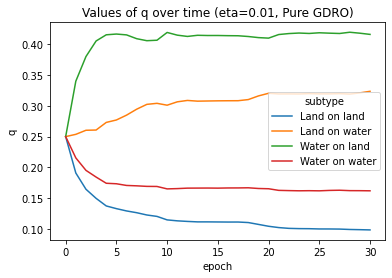

In [ ]:
q_df.plot(xlabel="epoch", ylabel="q", title=f"Values of q over time (eta={hparams['groupdro_eta']}, Pure GDRO)")

# Combining CNN features and engineered features

In [ ]:
cnn_df = pd.read_csv('data/cnn_features.csv')
for c in range(2, len(cnn_df.columns)):
    cnn_df.columns.values[c] = f'CNN_{cnn_df.columns.values[c]}'

eng_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
cnn_df = cnn_df[cnn_df['nodule_id'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]
eng_df = eng_df[eng_df['noduleID'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]

In [ ]:
concat_df = eng_df.copy()

In [ ]:
cnn_df.index = cnn_df['nodule_id']
for i in concat_df.index:
    for col in cnn_df.columns[2:]:
        concat_df.at[i, col] = cnn_df.at[concat_df.at[i, 'noduleID'], col]

In [ ]:
concat_df.drop(columns='Unnamed: 0').to_csv('data/AllFeatures2D_MaxSlice_with_CNN.csv', index=False)

,InstanceID,StudyInstanceUID,SeriesInstanceUid,RadiologistID,noduleID,DicomImage,FilePath,subtlety,internalStructure,calcification,...,CNN_27,CNN_28,CNN_29,CNN_30,CNN_31,CNN_32,CNN_33,CNN_34,CNN_35,CNN_36
0,4,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1,1,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0001\1.3.6.1....,5,1,6,...,-5.395743,1.582677,-4.063280,-5.070021,3.163702,5.290330,-2.523472,3.713529,-0.649701,4.314638
1,75,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,4,2,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0002\1.3.6.1....,1,1,6,...,-5.850334,5.002493,-3.661947,-3.624461,3.235335,-3.922062,-2.210064,6.059101,-0.500276,5.508437
2,134,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,3,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,5,1,6,...,-4.822973,2.920556,-5.047228,-5.552570,3.489042,0.851557,-2.870659,6.073289,-0.647323,6.486247
3,143,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,4,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,3,1,6,...,-7.574823,7.260141,-6.138217,-6.386428,4.904528,-2.540447,-2.647656,8.163655,-0.035022,8.056358
4,118,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,3,5,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,4,1,6,...,-7.165000,6.356084,-6.882338,-5.712488,5.102713,-2.921033,-2.749318,9.136231,-0.171229,8.867806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,30321,1.3.6.1.4.1.14519.5.2.1.6279.6001.112366982107...,1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727...,2,2686,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0770\1.3.6.1....,5,1,6,...,-4.363398,1.216722,-3.386296,-4.855748,2.966221,5.028000,-2.105534,4.931665,-0.734520,4.226719
2682,32539,1.3.6.1.4.1.14519.5.2.1.6279.6001.213747445868...,1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560...,2,2687,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0815\1.3.6.1....,4,1,6,...,-5.684091,4.747817,-3.803551,-3.821561,3.346258,-2.903088,-2.005761,5.487472,-0.402588,5.502116
2683,35559,1.3.6.1.4.1.14519.5.2.1.6279.6001.323769537371...,1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046...,4,2688,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0871\1.3.6.1....,4,1,6,...,0.528109,-2.443759,3.613519,5.157967,-0.401557,-2.264581,4.815277,-1.387713,-0.522287,-1.254572
2684,37212,1.3.6.1.4.1.14519.5.2.1.6279.6001.232772963487...,1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785...,4,2689,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0916\1.3.6.1....,1,1,6,...,1.710828,-2.952641,4.176023,7.256946,-0.778750,-2.928508,6.510663,-2.376418,-0.569608,-1.775246


In [ ]:
# code to get max slice data from the all slices set

# all_slices = pd.read_csv('data/LIDC_20130817_AllFeatures2D_AllSlices_MattEdited.csv')
# max_slices = []

# nodule_radiologist_pairings = set(zip(all_slices["RadiologistID"], all_slices["noduleID"]))

# for radiologist_id, nodule_id in nodule_radiologist_pairings:
#     nodule_data = all_slices.loc[(all_slices["RadiologistID"] == radiologist_id) & (all_slices["noduleID"] == nodule_id), :]
    
#     max_slice = nodule_data.iloc[np.argmax(nodule_data["Area"]), :]
#     max_slices.append(max_slice)

# max_slice_df = pd.DataFrame(max_slices).sort_values(["noduleID", "RadiologistID"], axis=0).reset_index().drop(columns="index")
# max_slice_df

In [ ]:
maxslice_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
correct_semantic_df = pd.read_csv('data/LIDC_labels.csv')

In [ ]:
correct_semantic_df.index = correct_semantic_df['noduleID'].values

In [ ]:
for i in maxslice_df.index:
  maxslice_df.loc[i, ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']] = correct_semantic_df.loc[maxslice_df.at[i, 'noduleID'], ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']].values

In [ ]:
maxslice_df[['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']]

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,5,1.0,6.0,3,4,3,5,5,5.0
1,2,1.0,6.0,4,2,1,1,2,5.0
2,5,1.0,6.0,4,3,2,2,4,5.0
3,4,1.0,6.0,4,4,1,2,5,4.0
4,4,1.0,6.0,5,5,1,1,5,4.0
...,...,...,...,...,...,...,...,...,...
2682,4,1.0,6.0,2,5,2,2,4,4.0
2683,3,1.0,6.0,3,4,1,1,5,2.0
2684,3,1.0,6.0,5,4,1,1,4,2.0
2685,5,1.0,6.0,3,5,3,2,5,5.0


,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,5,1,6,3,3,3,4,5,5.0
1,1,1,6,3,2,1,1,2,5.0
2,5,1,6,5,4,1,5,4,5.0
3,3,1,6,5,5,1,1,5,4.0
4,4,1,6,4,5,1,1,5,5.0
...,...,...,...,...,...,...,...,...,...
2682,4,1,6,2,5,2,2,4,4.0
2683,4,1,6,4,5,1,1,5,2.0
2684,1,1,6,5,2,1,1,2,2.0
2685,5,1,6,3,4,3,2,5,5.0


In [ ]:
maxslice_df.to_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
test_dataset

In [ ]:
test_loader = dataloaders.InfiniteDataLoader(test_dataset, 4)

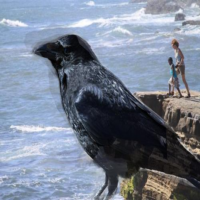

In [ ]:
to_image = torchvision.transforms.ToPILImage()
to_image(next(iter(test_loader))[0].squeeze()[0])

In [ ]:
next(iter(test_loader))[0].squeeze()

tensor([[[[0.2675, 0.3391, 0.3197,  ..., 0.2923, 0.4666, 0.3925],
          [0.3006, 0.3665, 0.3618,  ..., 0.3159, 0.5047, 0.3659],
          [0.2775, 0.3658, 0.3619,  ..., 0.3267, 0.3394, 0.2482],
          ...,
          [0.0819, 0.1514, 0.2360,  ..., 0.7976, 0.5740, 0.1655],
          [0.2273, 0.1637, 0.1929,  ..., 0.9357, 0.5133, 0.1262],
          [0.3615, 0.3426, 0.2790,  ..., 0.9345, 0.4706, 0.1360]],

         [[0.2448, 0.3075, 0.2795,  ..., 0.3262, 0.4785, 0.3932],
          [0.2793, 0.3362, 0.3227,  ..., 0.3427, 0.5138, 0.3694],
          [0.2586, 0.3378, 0.3253,  ..., 0.3566, 0.3528, 0.2537],
          ...,
          [0.1546, 0.2236, 0.3138,  ..., 0.7818, 0.5257, 0.1149],
          [0.3329, 0.2608, 0.2852,  ..., 0.9235, 0.4622, 0.0714],
          [0.4940, 0.4593, 0.3864,  ..., 0.9179, 0.4147, 0.0765]],

         [[0.3275, 0.3833, 0.3433,  ..., 0.2984, 0.4811, 0.4223],
          [0.3539, 0.4053, 0.3807,  ..., 0.3661, 0.5474, 0.3906],
          [0.3204, 0.3953, 0.3687,  ..., 0